# Sleep and Dream Database

This dataset is a compilation of various dream report surveys covering a wide range of contexts.

**Source:** [Sleep and Dream Database](https://sleepanddreamdataboase.rg)


## Notes

The original data file was compressed with LZMA to save space and make it possible to upload it to this GitHub repository since there is no direct download link to use (see `raw/`). The raw data are in `csv` format. The new output file will also be compressed with LZMA.

There are many assertion checks before cleaning steps, because I am not sure of the consistency over time with downloads and the format of the raw data file that gets downloaded from the SDDb `Export CSV` option.

In [1]:
import csv
import hashlib
import os
import pathlib
import random
import re
import string
import uuid

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Each unique author name will be replaced with a random ID. Make a function that will generate these IDs and start with the same random seed for reproducibility.

In [2]:
rd = random.Random()
rd.seed(2)

def random_id(n_chars: int = 8) -> str:
    """
    Return a random alpha-numeric character sequence (str) of length n_chars.
    Always starts with a capital letter, to encourage categorical interpretation later.
    """
    while True:
        id_string = uuid.UUID(int=rd.getrandbits(128)).hex
        if id_string[0].isalpha():
            return id_string[:n_chars].upper()

## Read the data

Read in the original data file, reduce to only columns-of-interest, and rename the columns.

In [3]:
# Load original data
df = pd.read_csv(
    pathlib.Path("raw") / "dream-export.csv.xz",
    low_memory=False,  # Set low_memory=False to avoid warning about mixed dtypes in columns
    parse_dates=["date"],
)

# Display the original DataFrame
df

,answer_text,word_count,dream_entry_title,date,respondent,survey,Religious Affiliation B,Familiar Settings,Non-Physical Aggression 3,Non-Physical Aggression 4,...,Country of Residence,ZIP Code,Mobile devices: smartphone,Mobile devices: standard mobile phone,Mobile devices: tablet,Mobile devices: eReader,Mobile devices: other mobile devices,Mobile devices: none,Personal Finances E,2020 President Trump approval
0,I have dreamed that everyone on Earth passed a...,24,Pandemic Dream Report,2020-06-19 04:22:13+00:00,2020pandemicapril:2125,2020 Pandemic April,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$40K to $80K,Disapprove
1,“In the evening they flourished by the grassy ...,9,last_nights_dream,2021-11-02 21:42:24+00:00,NaN,Aristides Journal 2nd century CE,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A snake was on my head and curled around someo...,15,Protest Dreams,2020-09-21 10:38:29+00:00,2020racialjustice:2004,2020 Racial Justice Survey,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,I was with someone in a grocery store and in a...,34,last_nights_dream4,2021-09-24 00:00:00+00:00,Vera,Vera Journal 2020,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"I am in a small airplane, maybe eight seats to...",178,Last Night's Dream,2021-09-29 00:00:00+00:00,KB,KB Journal 2019a,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39084,animals start contracting the virus and then i...,31,Pandemic Dream Report,2020-06-19 04:21:52+00:00,2020pandemicapril:2037,2020 Pandemic April,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Under $40K,Disapprove
39085,A man in his car. He’s stoned. He’s found out ...,245,last_nights_dream3,2019-12-26 00:00:00+00:00,Ana,Ana Journal 2020,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39086,nightmarish,1,Pandemic Dream Report,2020-06-10 09:10:45+00:00,2020pandemicsurvey:204,2020 Pandemic May,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$40K to $80K,Disapprove
39087,I’m on a piece of property with two houses. Th...,667,last_nights_dream,2019-12-21 00:00:00+00:00,Rose,Rose Journal 2020,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Reduce to a subset of relevant columns and reorder and rename for convenience
df = df[["survey", "respondent", "dream_entry_title", "answer_text"]]
df = df.rename(
    columns={
        "answer_text": "dream",
        "respondent": "author",
        "survey": "dataset",
        "dream_entry_title": "title",
    }
)

print("DataFrame shape after column reduction:", df.shape)

DataFrame shape after column reduction: (39089, 4)


It is useful to view a brief description of the dataset at various points. This view shows (indirectly) the amount of `NaNs` in each column; given a DataFrame of length `n`, the amount of missing values or `NaNs` is `n - count`.

In [5]:
# Display the description of the DataFrame at this point
df.describe().T.rename_axis("df_column")

,count,unique,top,freq
df_column,,,,
dataset,39089,83,2012 Demographic Survey,6756
author,38945,15785,Lucille,1009
title,39089,37,Dream Text: Last Night's Dream,12917
dream,37522,32599,none,2644


## Handle missing values

There are some missing values (i.e., `NaNs`) in the `author` and `dream` columns. The author values can be filled with the true values but any rows with a missing dream report need to be removed.

#### Fill/replace author NaN values

Some datasets have partially missing values for dreamer, so use fillna in both directions to take the existing value and fill in the missing values.

In [6]:
print("Number of author NaN values before correction:", df["author"].isna().sum())

for key in ["Anna Kingsford Journal 1876-1887", "Aristides Journal 2nd century CE"]:
    assert df.query(f"dataset=='{key}'")["author"].isna().any(), "No need to fill NaN if NaNs not present"
    df.loc[df["dataset"].eq(key), "author"] = df.loc[df["dataset"].eq(key), "author"].bfill().ffill()

print("Number of author NaN values after correction:", df["author"].isna().sum())

Number of author NaN values before correction: 144
Number of author NaN values after correction: 0


#### Remove dream NaN values

There are many `dream` column entries with `NaN` values. Those rows should be removed.

In [7]:
# Display the concern, including which datasets are driving the concern
df[df["dream"].isna()]["dataset"].value_counts().to_frame("NaN_count")

,NaN_count
dataset,
2012 Demographic Survey,1351
2011 Memorable Dream Survey,74
2013 Demographic Survey Winter,59
2013 Demographic Survey Summer,27
2011 Children's Dream Survey,24
2010 Demographic Survey,16
Santa Clara Dreams 2008,15
Lucid Dreams 2010,1


In [8]:
# Remove NaN dream values
print("DataFrame shape before removing `dream` NaNs:", df.shape)
df = df.dropna(subset="dream")
print("DataFrame shape after removing `dream` NaNs:", df.shape)

DataFrame shape before removing `dream` NaNs: (39089, 4)
DataFrame shape after removing `dream` NaNs: (37522, 4)


In [9]:
df.describe().T.rename_axis("df_column")

,count,unique,top,freq
df_column,,,,
dataset,37522,83,Online Dreams 2015,5904
author,37522,15341,Lucille,1009
title,37522,37,Dream Text: Last Night's Dream,12917
dream,37522,32599,none,2644


## Clean dream reports

These steps are **not** extensive and any downstream analyses of this data should take additional steps of data inspection and cleaning. The purpose is only to provide minimal cleaning that allows for standardization across dream reports, such as formatting.

#### Remove spaces surrounding dream text

Dream reports sometimes contain extra spaces before and/or after the text. These only add confusion during data analysis and can easily be removed.

In [10]:
# Remove leading and/or trailing whitespace
print("Number of dreams with leading or trailing whitespace before correction:", df["dream"].str.fullmatch(r"(\s+.+|.+\s+)").sum())
df["dream"] = df["dream"].str.strip()
print("Number of dreams with leading or trailing whitespace after correction:", df["dream"].str.fullmatch(r"(\s+.+|.+\s+)").sum())

Number of dreams with leading or trailing whitespace before correction: 3782
Number of dreams with leading or trailing whitespace after correction: 0


#### Remove quotes surrounding dream text

Similarly, dream reports sometimes contain quotes surrounding the _entire_ dream text. This also only adds confusing data analysis and can be removed.

In [11]:
# Remove leading AND trailing quotes
# For dream reports that start with a quote and end with a quote, but are **not** one full quote, the quotes should stay
quoted_patterns = [
    r"^“([^“”]+)”$",
    r"^‘([^‘’]+)’$",
    r"^'([^']+)'$",
    r'^"([^"]+)"$',
]

for pattern in quoted_patterns:
    n_before = df["dream"].str.fullmatch(pattern).sum()
    df["dream"] = df["dream"].str.replace(pattern, lambda m: m.group(1), regex=True)
    n_after = df["dream"].str.fullmatch(pattern).sum()
    print(f"Number of {pattern[1]}quoted{pattern[-2]} dreams before/after correction: {n_before}/{n_after}")

Number of “quoted” dreams before/after correction: 6/0
Number of ‘quoted’ dreams before/after correction: 0/0
Number of 'quoted' dreams before/after correction: 36/0
Number of "quoted" dreams before/after correction: 17/0


## Filter rows based on dream reports

#### Remove dream text indicative of no dream recall/report

No dream recall: Many dream reports contains single words like "none", "no", "No", "na", etc. and short phrases like "don't remember". While these will all get removed when limiting word count and/or when dropping duplicates, try to catch most here in the _correction_ step rather than filtering. They are not really dreams in the first place. This filter also includes single letters, which are essentially non-responses, but leaves other button-mashing responses like `dqwkjnkfn` because other single-word entries like `Falling` and `nightmarish` might still be considered recall. No dream report: Short phrases like "yes" are also removed based on this not really being a useful dream report.

> **Note: This step is essentially redundant with the (much simpler) subsequent step of removing dream reports with low word count.** Almost all entries identified and removed here have very small (<10) word counts and would get removed later anyways. I'm keeping it here to highlight the content of the original dataset and in case future versions of this script reduce or remove the word count restriction.

In [12]:
# Generate a custom list of phrases relating to no recall that have been observed in the dataset
nonrecall_patterns = [
    r"\S?n+o+\S*",  # This one catches almost everything (see previous cell output)
    r"(i )?((do|ca)(n'?t| not)|no) (remember|recall|know|dream)( my)?( dream)?\S*",  # don't remember, I don't recall., I do not recall, i dont know
    r"\.\s?\S*",  # ., ..., ....., ...no., .pop, ". ,nlmbhv"
    r"no(t|ne|pe|thing)?\S?(\s+\S+){,50}",  # No - I don't recall anything like that., nothing off the top of my head.
    r"[ui]nknown",  # unknown, UNKNOWN, inknown
    r"\S?nothing\S?",  # nothing, Nothing, Nothing!
    r"\S?yes\S*",  # yes, yes., yes/no
    r"\S?n\S?a\S?",  # n.a, na, naa, nah, naw, N/A.
    r".{1,2}",  # One or two character sequences, like f, g, 4, ., ?, ??, -, etc.
    r"(\S)\1+",  # repeated characters like Gggg, Zzz, mmmmmmm, and one entry that is just 207 x's
]

In [13]:
# Display some of the concerns
df[df["dream"].str.fullmatch(nonrecall_patterns[0], flags=re.IGNORECASE)].dream.value_counts().sort_index(key=lambda s: s.str.lower()).to_frame()

,count
dream,
NNone,1
no,461
No,118
NO,24
No!!,1
No.,18
no.,3
noe,1
Nome,1


In [14]:
df[df["dream"].str.fullmatch(nonrecall_patterns[1], flags=re.IGNORECASE)].dream.value_counts().sort_index(key=lambda s: s.str.lower()).to_frame()

,count
dream,
Can't recall,3
can't recall,3
can't remember,38
Can't remember,22
Can't Remember,1
...,...
I dont remember my dreams,2
no dream,2
No dream,1


In [15]:
# Remove rows that match non-recall patterns
print("DataFrame shape before non-recall corrections", df.shape)
for pattern in nonrecall_patterns:
    n_before = df["dream"].str.fullmatch(pattern, flags=re.IGNORECASE).sum()
    df = df[~df["dream"].str.fullmatch(pattern, flags=re.IGNORECASE)]
    n_after = df["dream"].str.fullmatch(pattern, flags=re.IGNORECASE).sum()
    print(f"Number of dream {pattern} matches before/after correction: {n_before}/{n_after}")
print("DataFrame shape after non-recall corrections", df.shape)

DataFrame shape before non-recall corrections (37522, 4)
Number of dream \S?n+o+\S* matches before/after correction: 3464/0
Number of dream (i )?((do|ca)(n'?t| not)|no) (remember|recall|know|dream)( my)?( dream)?\S* matches before/after correction: 560/0
Number of dream \.\s?\S* matches before/after correction: 31/0
Number of dream no(t|ne|pe|thing)?\S?(\s+\S+){,50} matches before/after correction: 338/0
Number of dream [ui]nknown matches before/after correction: 3/0
Number of dream \S?nothing\S? matches before/after correction: 0/0
Number of dream \S?yes\S* matches before/after correction: 116/0
Number of dream \S?n\S?a\S? matches before/after correction: 193/0
Number of dream .{1,2} matches before/after correction: 69/0
Number of dream (\S)\1+ matches before/after correction: 30/0
DataFrame shape after non-recall corrections (32718, 4)


In [16]:
# Display the description of DataFrame at this point
df.describe().T.rename_axis("df_column")

,count,unique,top,freq
df_column,,,,
dataset,32718,83,Online Dreams 2015,5903
author,32718,13216,Lucille,1009
title,32718,37,Dream Text: Last Night's Dream,12916
dream,32718,32107,flying,11


#### Remove dreams with extreme word counts

Many dream reports are too short to be useful for analysis and should be removed. This step is also important in catching any spam or button-mashed responses. Some long dreams are outliers than muck up future analyses.

> **Note:** This is a very crude word count, only used for preliminary and quick processing. There are many ways to count words in a text, with none being a universal standard. Therefore, as with other steps here, any downstream analyses of this dataset should implement their own method of counting words.

In [17]:
# Get word count for each dream
def count_words(s):
    return len(re.findall(r"\w+", s))

n_words = df["dream"].apply(count_words)

# Display the word count distribution before removing short dream reports
n_words.describe().to_frame("n_words").round(2).T

,count,mean,std,min,25%,50%,75%,max
n_words,32718.0,104.92,160.55,1.0,27.0,63.0,122.0,2804.0


In [18]:
MIN_WORDCOUNT = 10  # inclusive
MAX_WORDCOUNT = 1000  # inclusive
print("DataFrame shape before removing dream reports with extreme lengths:", df.shape)
n_lt = n_words.lt(MIN_WORDCOUNT).sum()
n_gt = n_words.gt(MAX_WORDCOUNT).sum()
df = df[n_words.between(MIN_WORDCOUNT, MAX_WORDCOUNT, inclusive="both")]

print(f"Removed {n_lt} dream reports with less than {MIN_WORDCOUNT} words.")
print(f"Removed {n_gt} dream reports with more than {MAX_WORDCOUNT} words.")

print("DataFrame shape after removing dream reports with extreme lengths:", df.shape)

DataFrame shape before removing dream reports with extreme lengths: (32718, 4)
Removed 3548 dream reports with less than 10 words.
Removed 231 dream reports with more than 1000 words.
DataFrame shape after removing dream reports with extreme lengths: (28939, 4)


#### Remove duplicate dream reports

Aside from trivial dream report duplicates (e.g., "no recall"), there is a decent amount of lengthy dream reports that are identical and clearly not occurring by chance. Sometimes they are from the same authors (in which case pay attention to the `title` column that might separate them), but other times they are from different authors, which makes less sense.

In [19]:
# Display the concern
df[df.duplicated(subset="dream", keep=False)].sort_values("dream")

,dataset,author,title,dream
26912,Dreamboard Nightmares 2014,dreamboarda:dreamboarda50,Dream text: Nightmares,*Translated from French* I go alone at night I...
26913,Dreamboard Nightmares 2014,dreamboarda:dreamboarda51,Dream text: Nightmares,*Translated from French* I go alone at night I...
30750,Online Dreams 2015,recent_dreams_2015:55336,Dream Text: Last Night's Dream,- wing commander style dream. One where it was...
30751,Online Dreams 2015,recent_dreams_2015:55336,Dream Text: Last Night's Dream,- wing commander style dream. One where it was...
31109,Online Dreams 2015,recent_dreams_2015:63471,Dream Text: Last Night's Dream,... I am at work in building B cleaning out so...
...,...,...,...,...
27749,Nepal Dreams 2014,nepaldreams:anjana_t,Dream Text: Significant Dream,[In one of my dreams I saw a dead member of my...
7229,2010 Demographic Survey,zogby_052110:19255,Dream Text: Worst Nightmare,sliding down dark stairway to basement in chil...
6249,2010 Demographic Survey,zogby_052110:19255,Dream Text: Earliest Remembered Dream,sliding down dark stairway to basement in chil...
34968,Magnolia Journal 2015,magnolia1:magnolia,Dream Text: Last Night's Dream,“Durango” I went with Evan and Jim to get cof...


For a current solution, just remove all duplicates (keeping only the first entry). This makes sense for duplicates that come from the same author, but for those that come from different authors it means the second author gets knocked out. I see no big problem with this and no better solution.

In [20]:
# Remove duplicate dream reports
n_duplicates = df.duplicated(subset="dream", keep="first").sum()
print("Number of duplicated dream entries:", n_duplicates)
print("DataFrame shape before removing `dream` duplicates:", df.shape)
df = df.drop_duplicates(subset="dream", keep="first")
print("DataFrame shape after removing `dream` duplicates:", df.shape)

Number of duplicated dream entries: 364
DataFrame shape before removing `dream` duplicates: (28939, 4)
DataFrame shape after removing `dream` duplicates: (28575, 4)


In [21]:
# Display the description of DataFrame at this point
df.describe().T.rename_axis("df_column")

,count,unique,top,freq
df_column,,,,
dataset,28575,83,Online Dreams 2015,5737
author,28575,10646,Lucille,988
title,28575,37,Dream Text: Last Night's Dream,12410
dream,28575,28575,I have dreamed that everyone on Earth passed a...,1


## Clean metadata

####  Consolidate and rename datasets

The original dataset names are not standardized, and often there are a few datasets that could be grouped together. For example, `2010 Demographic Survey` and `2012 Demographic Survey` can be merged by changing both to `demographic`.

In [22]:
# Display a bit of the original dataset names
df["dataset"].value_counts().sort_index().to_frame().head(15)

,count
dataset,
2010 Demographic Survey,2195
2011 Children's Dream Survey,766
2011 Memorable Dream Survey,1197
2012 Demographic Survey,1582
2013 Demographic Survey Summer,1298
2013 Demographic Survey Winter,1009
2020 Pandemic April,93
2020 Pandemic May,174
2020 Racial Justice Survey,145


In [23]:
dataset_renames = {
    "2010 Demographic Survey": "demographic",
    "2011 Children's Dream Survey": "children",
    "2011 Memorable Dream Survey": "memorable",
    "2012 Demographic Survey": "demographic",
    "2013 Demographic Survey Summer": "demographic",
    "2013 Demographic Survey Winter": "demographic",
    "2020 Pandemic April": "pandemic",
    "2020 Pandemic May": "pandemic",
    "2020 Racial Justice Survey": "justice",
    "AD Journals: Lola, Paul, Sophia, Will 2006-2007": "dj-ad",
    "African Church Dreams A": "africanchurch",
    "African Church Dreams B": "africanchurch",
    "African Church Dreams C": "africanchurch",
    "Ana Journal 2020": "dj-ana",
    "Anna Kingsford Journal 1876-1887": "dj-kingsford",
    "Anthropological Dreams": "anthropological",
    "Aristides Journal 2nd century CE": "dj-aristides",
    "Barack Obama Dreams 2008": "obama",
    "Barb Sanders baseline 250": "dj-barb",
    "Bea Journal 2003-2005": "dj-bea",
    "Bea Journal 2007-2010": "dj-bea",
    "Beverly Journal 1986": "dj-beverly",
    "Beverly Journal 1996": "dj-beverly",
    "Beverly Journal 2006": "dj-beverly",
    "Beverly Journal 2016": "dj-beverly",
    "Burgess Journal 2020": "dj-burgess",
    "Dreamboard Nightmares 2014": "dreamboard",
    "Film-Related Dreams": "film",
    "Francine Journal 2015": "dj-francine",
    "Freya Journal 1981-2019": "dj-freya",
    "Freya Journal 2020": "dj-freya",
    "Hall & Van de Castle Female Norms 1947-1950": "hvdc",
    "Hall & Van de Castle Male Norms 1947-1950": "hvdc",
    "Hillary Clinton Dreams 2008": "clinton",
    "Historical Dreams": "historical",
    "Janet Journal 2012-2013": "dj-janet",
    "Jasmine Journal A": "dj-jasmine",
    "Jasmine Journal B": "dj-jasmine",
    "Jasmine Journal C": "dj-jasmine",
    "Jasmine Journal D": "dj-jasmine",
    "Jordan Dream Journal": "dj-jordan",
    "KB Journal 2012": "dj-kb",
    "KB Journal 2019a": "dj-kb",
    "KB Journal 2020": "dj-kb",
    "KB Journal 2022": "dj-kb",
    "KM Journal 2015": "dj-km",
    "Krippner International Survey 1990-2005": "krippner",
    "Lawrence Journal 2011": "dj-lawrence",
    "Literary Dreams": "literary",
    "Lucid Dreams 2010": "lucid",
    "Lucid Dreams Study 2018 A": "lucid",
    "Lucid Dreams Study 2018 B": "lucid",
    "Lucille Journal 1998-2018": "dj-lucille",
    "Lucrecia de Leon Journal 1587-1588 ": "dj-lucrecia",
    "Lucrecia de Leon Journal 1590": "dj-lucrecia",
    "Magnolia Journal 2015": "dj-magnolia",
    "Mary Journal 2020": "dj-mary",
    "Maxwell Journal 2015": "dj-maxwell",
    "Mehinaku of Brazil Dreams 1970's": "mehinaku",
    "Melvin Journal 2020": "dj-melvin",
    "Miami Home Dreams 1964-1965": "miami",
    "Miami Lab Dreams 1963-1965": "miami",
    "Mike Journal 1970": "dj-mike",
    "Myoe Shonin Journal 13th century CE": "dj-myoeshonin",
    "Nan Journal 2001-2002": "dj-nan",
    "Natural Scientist Journal 1939": "dj-natsci",
    "Nepal Dreams 2014": "nepal",
    "Online Dreams 2015": "onlinedreams",
    "Palliative Care Dreams 2011": "palliative",
    "RB Journal 1996": "dj-rb",
    "Research Study 2015 A": "researchstudy",
    "Research Study 2015 B": "researchstudy",
    "Rosa Journal 2020": "dj-rosa",
    "Rose Journal 2020": "dj-rose",
    "Santa Clara Dreams 2008": "santaclara",
    "Santa Clara Dreams 2012": "santaclara",
    "Sports Dreams Survey 2021": "sports",
    "Swedenborg Journal 1743-1744": "dj-swedenborg",
    "Tanya Journal 2003-2013": "dj-tanya",
    "Tita Journal 2020": "dj-tita",
    "Trump Dreams 2016-2017": "trump",
    "Vera Journal 2020": "dj-vera",
    "Wolfgang Pauli dreams 1930's": "dj-pauli",
}

In [24]:
# Make sure that the custom dictionary includes a key for all original dataset names, and nothing else
for key in df["dataset"].unique():
    if key not in dataset_renames:
        print(f"Dataset {key} in raw file but not in remapping dict")
for key in dataset_renames:
    if key not in df["dataset"].unique():
        print(f"Dataset {key} in remapping dict but not in raw file")
assert sorted(df["dataset"].unique()) == sorted(dataset_renames)

# Replace the original dataset names with new ones from custom dictionary
df = df.replace({"dataset": dataset_renames})

# Display a bit of the new dataset names
df["dataset"].value_counts().sort_index().to_frame().head(10)

,count
dataset,
africanchurch,140
anthropological,3
children,766
clinton,99
demographic,6084
dj-ad,449
dj-ana,255
dj-aristides,111
dj-barb,250


#### Split "AD Journal" dataset into individual datasets

The dataset originally titled `AD Journals: Lola, Paul, Sophia, Will 2006-2007` is a collection of multiple dream journals, so split each of them into their own individual dataset using the `author` column that will have each respective author name.

In [25]:
# Display the concern
df.loc[df["dataset"].eq("dj-ad"), ["dataset", "author"]].value_counts().to_frame()

count
dataset author              
dj-ad   ad2007_paul      136
        ad2007_sophia    115
        ad2007_lola      102
        ad2007_will       96

In [26]:
new_ad_journal_datasets = df.loc[df["dataset"].eq("dj-ad"), "author"].str.split("_").str[1].radd("dj-")
assert not new_ad_journal_datasets.isin(df["dataset"]).any(), "New dataset name conflicts with existing dataset name"
df.loc[df["dataset"].eq("dj-ad"), "dataset"] = new_ad_journal_datasets

# Display the resolution
df["dataset"].value_counts().loc[new_ad_journal_datasets.unique()].to_frame()

,count
dataset,
dj-lola,102
dj-paul,136
dj-sophia,115
dj-will,96


#### Consolidate author names

Some dream journals appear to have multiple authors but it's just spelling variants. This is also a consequence of the previous step where dataset names were consolidated. Here we want to make sure each dream journal dataset has only 1 author.

In [27]:
# Display the problem
df.query("dataset.str.startswith('dj-')").groupby("dataset")["author"].value_counts().to_frame()

count
dataset       author                                            
dj-ana        Ana                                            255
dj-aristides  P. Aelius Aristides                            111
dj-barb       bs_250:barb_sanders                            250
dj-bea        bea_series:bea                                 281
dj-beverly    beverly_1986:beverly                           247
              beverly_1996:beverly                           239
              beverly_2006:beverly                           236
              beverly_2016:beverly                           183
dj-burgess    Burgess                                         48
dj-francine   francine_2015:francine                          68
dj-freya      2020_dreams:freya                              133
              freya_series_1:freya                             8
dj-janet      janet1:janet                                    73
dj-jasmine    jasmine_journala:jasmine                       332
              jasmine_journalb:jasmine                       215
              jasmine_journald:jasmine                       147
              jasmine_journalc:jasmine                        92
dj-jordan     jordan_series:jordan                           124
dj-kb         KB                                             729
              kb_dj_2012a:kb                                 201
              KB:1                                             1
dj-kingsford  anna_kingsford_series:anna_kingsford            19
dj-km         km2015:km                                      290
dj-lawrence   lawrence_journal_2011:lawrence                 206
dj-lola       ad2007_lola                                    102
dj-lucille    Lucille                                        988
dj-lucrecia   lucrecia_1:lucrecia                             24
              Lucrecia de Leon                                 6
dj-magnolia   magnolia1:magnolia                             100
dj-mary       Mary                                            77
dj-maxwell    maxwell_2015:maxwell                            71
dj-melvin     2020_dreams:melvin                             279
dj-mike       mike_journal:mike                               97
dj-myoeshonin Myoe Shonin                                    168
dj-nan        nan_series:nan                                  26
dj-natsci     natural_scientist_journal:natural_scientist    234
dj-paul       ad2007_paul                                    136
dj-pauli      paulidreams:pauli                               54
dj-rb         rb_dreams:rb                                    51
dj-rosa       Rosa                                            46
dj-rose       Rose                                           135
dj-sophia     ad2007_sophia                                  115
dj-swedenborg swedenborg_dreams:emanuel                      118
dj-tanya      tanya1:tanya                                   553
dj-tita       Tita                                            47
dj-vera       Vera                                           320
dj-will       ad2007_will                                     96

In [28]:
# Create a dictionary that maps original author names to new author names
dj_authors = df.query("dataset.str.startswith('dj-')").groupby("dataset")["author"].unique().explode().to_frame("old_author")
dj_authors["new_author"] = dj_authors.index.str.split("-").str[1]
dj_authors_old2new = dj_authors.set_index("old_author")["new_author"].to_dict()

# Replace the original author names with the new author names
df = df.replace({"author": dj_authors_old2new})

# Display the solution
df.query("dataset.str.startswith('dj-')").groupby("dataset")["author"].value_counts().to_frame()

,,count
dataset,author,
dj-ana,ana,255
dj-aristides,aristides,111
dj-barb,barb,250
dj-bea,bea,281
dj-beverly,beverly,905
dj-burgess,burgess,48
dj-francine,francine,68
dj-freya,freya,141
dj-janet,janet,73


## Filter rows based on metadata

#### Remove datasets that don't have enough data

Some of the datasets start with very low counts, and some have low counts after all the filtering/cleaning. Either way, remove them from the final file.

In [29]:
# Drop datasets that don't have enough data in them
dataset_counts = df.value_counts(subset="dataset", dropna=False)
keep_datasets = dataset_counts[dataset_counts.ge(10)].index.tolist()
for d in df["dataset"].unique():
    if d not in keep_datasets:
        print(f"Dropped {d} dataset for low row count of {dataset_counts.at[d]}")
df = df.query(f"dataset.isin({keep_datasets})")

Dropped literary dataset for low row count of 2
Dropped anthropological dataset for low row count of 3


In [30]:
# Display the solution
df.value_counts(subset="dataset").to_frame("n_dreams").T

dataset,demographic,onlinedreams,krippner,memorable,santaclara,dj-lucille,hvdc,dj-kb,dj-beverly,dj-jasmine,...,dj-pauli,dj-rb,dj-burgess,dj-tita,dj-rosa,dj-lucrecia,dj-nan,historical,dj-kingsford,film
n_dreams,6084,5737,1427,1197,1165,988,981,931,905,786,...,54,51,48,47,46,30,26,24,19,14


## Tidying

Final tidying-up steps before describing and exporting.

#### Standardize author IDs

In [31]:
# Replace each unique author with a random ID
author2id_mapping = {k: random_id() for k in df["author"].unique()}
assert len(author2id_mapping.values()) == len(set(author2id_mapping.values()))
df = df.replace({"author": author2id_mapping})

# Display the impact on DataFrame
df["author"].value_counts().to_frame("n_dreams").T

author,EF8ACD12,CDBD47D3,DBCCAAD0,C15DD225,FEDEB4DA,FFED9235,FD255F4F,C5145947,E2520E33,EAB3B8D2,...,E70868A0,DF5D9268,D88C23B0,A14E9400,BFB8E3ED,B23AE75E,B4A34A02,A27CE68A,C0A9EA25,CE87D8BA
n_dreams,988,931,905,786,553,320,290,281,279,268,...,1,1,1,1,1,1,1,1,1,1


#### Remove column(s)

The title column was useful in diagnosing issues during preparation, but is not currently important for future analyses.

In [32]:
# Drop the column title out
df = df.drop(columns="title")

#### Sort values and reset index

Sort values and reset index for cleanliness, even though index won't be included in the export.

In [33]:
df = df.sort_values(["dataset", "author", "dream"])
df = df.reset_index(drop=True)

## Describe

Provide summary images of the prepared dataset.

In [34]:
df

,dataset,author,dream
0,africanchurch,A06911D1,I dreamed in the afternoon after eating my noo...
1,africanchurch,A3EC5C1A,I was in a group of people. We were singing so...
2,africanchurch,A504E898,I dreamed I saw the globe of the world. On it ...
3,africanchurch,A504E898,Last year (1987) I dreamed I saw much dust and...
4,africanchurch,A504E898,"Then the very day, at night, immediately as I ..."
...,...,...,...
28565,trump,FEDBD371,I was in some kind of dormitory or rehab cente...
28566,trump,FF2093CA,The only thing i remember is that i saw money ...
28567,trump,FF47AD00,I was wind surfing and the wind was good so I ...
28568,trump,FF7F9525,He was coming to an event and he was driving t...


#### Dream length

There are a few ways to quantify dream length. While we used a particular one for the word count cutoffs, we should inspect the final dataset in a few other ways, such as character count and word count using a different tokenizer method. It's also important to visualize the word count across all reports, within each user, and within each dataset.

In [35]:
# Calculate dream report length in a few different ways
lengths = pd.DataFrame(
    {
        "n_words_regex": df["dream"].str.findall(r"\w+").str.len(),
        "n_words_split": df["dream"].str.split().str.len(),
        "n_chars": df["dream"].str.len(),
    }
)

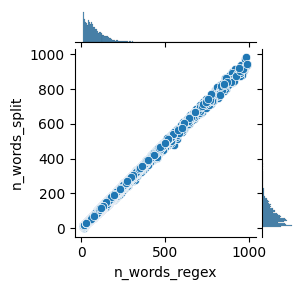

In [36]:
g = sns.jointplot(data=lengths, x="n_words_regex", y="n_words_split", height=3)

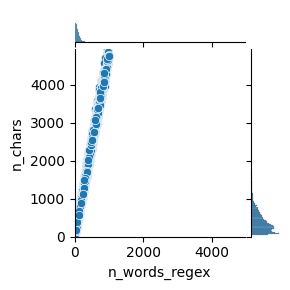

In [37]:
highest_value = lengths[["n_words_regex", "n_chars"]].max(None)
axis_limits = (0, highest_value)
g = sns.jointplot(data=lengths, x="n_words_regex", y="n_chars", height=3, xlim=axis_limits, ylim=axis_limits)

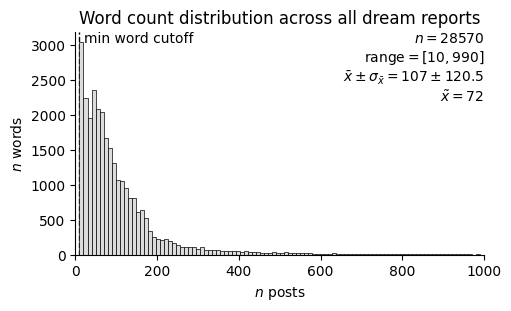

In [38]:
hist_values = lengths["n_words_regex"].to_numpy()
n, mean, sd, median, min_, max_ = lengths["n_words_regex"].describe().loc[["count", "mean", "std", "50%", "min", "max"]]

fig, ax = plt.subplots(figsize=(5, 3), constrained_layout=True)
linecolor = "black"
linewidth = 0.5
bins = 100
bar_kwargs = {
    "alpha" : 1,
    "color" : "gainsboro",
    "clip_on" : False,
}
ax.hist(hist_values, bins=bins, edgecolor=linecolor, linewidth=linewidth, **bar_kwargs)
ax.set_xlabel(r"$n$ posts")
ax.set_ylabel(r"$n$ words")
ax.set_xlim(0, MAX_WORDCOUNT)

descriptives_strings = [
    fr"$n={n:.0f}$",
    fr"$\text{{range}}=[{min_:.0f}, {max_:.0f}]$",
    fr"$\bar{{x}}\pm\sigma_{{\bar{{x}}}}={mean:.0f}\pm{sd:.1f}$",
    fr"$\tilde{{x}}={median:.0f}$",
]

ax.text(1, 1, "\n".join(descriptives_strings), transform=ax.transAxes, ha="right", va="top")
line_kwargs = {
    "linewidth" : 1,
    "alpha"     : 1,
    "color"     : "black",
    "linestyle" : "dashed",
    "clip_on"   : False,
    "zorder"    : 0,
}
ax.axvline(MIN_WORDCOUNT, **line_kwargs)
ax.text(MIN_WORDCOUNT + 10, 1, "min word cutoff", transform=ax.get_xaxis_transform(), ha="left", va="top")
ax.spines[["top", "right"]].set_visible(False)
ax.set_title("Word count distribution across all dream reports");

In [39]:
# n_words = df["n_words_regex"]
# n_words_per_user = df.groupby("author")["n_words_regex"].mean()
# n_words_per_dataset = df.groupby(["dataset", "author"])["n_words_split"].mean()

#### Character inspection

View the amount of different character types within the dataset. This step is mostly to inspect quality of previous data cleaning steps.

In [40]:
char_counts = pd.DataFrame(
    {
        "letters": df["dream"].str.findall(r"[a-zA-Z]").str.len(),
        "digits": df["dream"].str.findall(r"[0-9]").str.len(),
        "punctuation": df["dream"].str.findall(fr"[{string.punctuation}]").str.len(),  # !! Only checks for ASCII punctuation
        "whitespace": df["dream"].str.findall(r"\s").str.len(),
        "other": df["dream"].str.findall(fr"[^a-zA-Z0-9\s{string.punctuation}]").str.len(),  # everything not captured above
    }
)

C:\Users\malle\miniconda3\Lib\site-packages\numpy\lib\function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


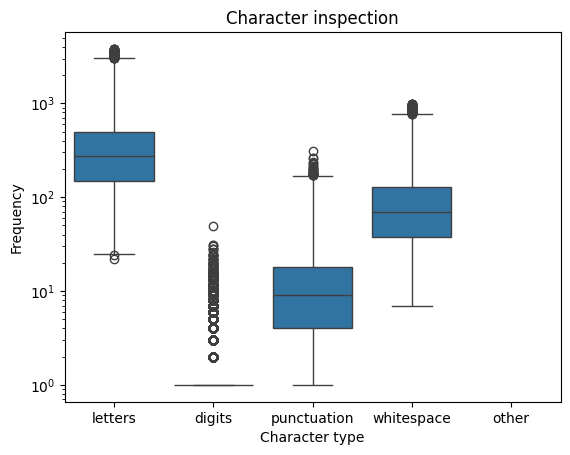

In [41]:
char_counts_melt = char_counts.melt(var_name="character_type", value_name="frequency")
ax = sns.boxplot(data=char_counts_melt, x="character_type", y="frequency", log_scale=True)
ax.set_xlabel("Character type")
ax.set_ylabel("Frequency")
ax.set_title("Character inspection");

#### Dataset and author counts

Visualize the relationship between dataset and unique author count.

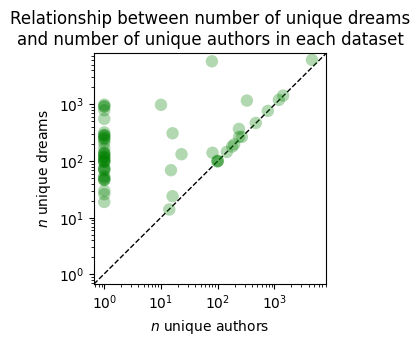

In [42]:
counts_per_dataset = df.groupby("dataset")[["author", "dream"]].nunique()

_, ax = plt.subplots(figsize=(3, 3))
ax.scatter(counts_per_dataset["author"], counts_per_dataset["dream"], s=80, alpha=0.3, color="green", edgecolor="none")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_aspect("equal", adjustable="datalim")
bounds = ax.get_xlim() + ax.get_ylim()
axis_lim = (min(bounds), max(bounds))
ax.set_xlim(axis_lim)
ax.set_ylim(axis_lim)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color="black", linestyle="dashed", linewidth=1, zorder=0)
ax.set_xlabel(r"$n$ unique authors")
ax.set_ylabel(r"$n$ unique dreams")
ax.set_title("Relationship between number of unique dreams\nand number of unique authors in each dataset");

#### Common words

Visualize the most common words with a word cloud or shift graph.

## Export

#### Write to file

Save prepared file with LZMA compression to save space.

In [43]:
# Make sure there are no empty cells left after processing
assert df.notna().all(None)
assert df.map(len).gt(0).all(None)

outpath = "sddb.tsv.xz"

df.to_csv(
    path_or_buf=outpath,
    index=False,
    sep="\t",
    mode="x",
    encoding="utf-8",
    compression="xz",
    quoting=csv.QUOTE_NONNUMERIC,
    quotechar='"',
    lineterminator="\n",
    doublequote=True,
)

def file_hash(fname, alg, chunksize=65536):
    """Calculate the hash of a given file in chunks to avoid memory overload"""
    hasher = getattr(hashlib, alg)()
    with open(fname, "rb") as f:
        buffer = f.read(chunksize)
        while buffer:
            hasher.update(buffer)
            buffer = f.read(chunksize)
    return hasher.hexdigest()

# Print details that will get manually copied to README.md
print(f"file: {outpath}")
print(f"size: {os.path.getsize(outpath) / 1e6} Mb")
for alg in ["md5", "sha256"]:
    print(f"{alg}:{file_hash(outpath, alg=alg)}")

file: sddb.tsv.xz
size: 4.133496 Mb
md5:082496b09f8973e511e15190bc344ac1
sha256:42fcb9e4f847f72cf64f20ca4f50d0028ee514d8bdfdcbe999dc9c2f02d5ac29


### Read new data back in

Read it back in and make sure it was not corrupted during output.

In [44]:
df_ = pd.read_csv(outpath, sep="\t")
assert df_.equals(df)

df

,dataset,author,dream
0,africanchurch,A06911D1,I dreamed in the afternoon after eating my noo...
1,africanchurch,A3EC5C1A,I was in a group of people. We were singing so...
2,africanchurch,A504E898,I dreamed I saw the globe of the world. On it ...
3,africanchurch,A504E898,Last year (1987) I dreamed I saw much dust and...
4,africanchurch,A504E898,"Then the very day, at night, immediately as I ..."
...,...,...,...
28565,trump,FEDBD371,I was in some kind of dormitory or rehab cente...
28566,trump,FF2093CA,The only thing i remember is that i saw money ...
28567,trump,FF47AD00,I was wind surfing and the wind was good so I ...
28568,trump,FF7F9525,He was coming to an event and he was driving t...
